# Milestone M1c - Iterative reconstruction algorithms

The third deliverable for the **PREDATOR** project Milestone M1 was to develop the basic linear operators describing the MR signal encoding.
Currently, the [DeepMR](https://github.com/INFN-PREDATOR/deep-mr) framework includes the following MR encoding operators:

* **CoilOp**: operator representing the effect of the RF coil profile on received signals. Supports multi-channel RF coil arrays and multiple sets of maps (e.g., for [soft-SENSE](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4142121/) approaches).
* **FFTop**: operator representing the Fourier encoding for Cartesian sampling. Supports arbitrary sampling masks in dense zero-filled format.
* **SparseFFTop**: operator representing the Fourier encoding for Cartesian sampling. Supports arbitrary sampling masks in sparse COO format.
* **NUFFTop**: operator representing the Fourier encoding for Non-Cartesian sampling. Supports arbitrary non-uniform sampling patterns.

Each operator has been implemented in forward, adjoint and self-adjoint mode, and supports [efficient projection](https://archive.ismrm.org/2022/2771.html) to low-rank subspace (e.g., for model-based dynamic MRI and quantitative MRI). In addition, each operator has been wrapped as a [deepinv.physics.LinearPhysics](https://deepinv.github.io/deepinv/stubs/deepinv.physics.LinearPhysics.html#deepinv.physics.LinearPhysics) model: as this is also a subclass of [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), [DeepMR encoding operators](https://infn-predator.github.io/deep-mr/core/linops.html) can be combined to build Neural Network architectures.

Here, we show two examples (Cartesian and Non-Cartesian imaging, respectively), each consisting in 1) generating a numerical phantom, coil sensitivity profiles and sampling pattern, 2) applying the forward encoding model to generate k-space, 3) applying the adjoint model to obtain a zero-filled representation of the reconstructed image and 4) showcasing the application of self-adjoint for iterative algorithms.

In [1]:
%matplotlib inline
import copy

import torch
import numpy as np
import matplotlib.pyplot as plt # for displaying the results

import deepmr

def load_challenge_rawdata(accel, datapath="../data/projection_ksp.npy", acqheaderpath="../data/projection_coord.npy"):
    """
    Read rawdata (in Numpy format) from the ISMRM Reproducibility Challenge.

    Parameters
    ----------
    datapath : str
        Path to raw data on disk.
        The default is "../data/projection_ksp.npy".
    acqheaderpath : str
        Path to acquisition header (here, k-space trajectory) on disk.
        The default is "../data/projection_coord.npy".

    Returns
    -------
    data : torch.Tensor
        Complex-valued raw k-space data of shape (nslices=1, ncoils=12, ncontrasts=1, nviews=96, nsamples=512).
    head : deepmr.Header
        Acquisition header containing trajectory, shape and dcf.
    img0 : teorch.Tensor
        "Grount truth" non-accelerated reconstruction of shape (128, 128).
        
    """
    # load rawdata (ncoils, nviews, nsamples)
    data = np.load(datapath)

    # prepare for DeepMR (nslices=1, ncoils, ncontrasts=1, nviews, nsamples)
    data = torch.as_tensor(data[None, :, None, ...], dtype=torch.complex64)

    # load radial trajectory trajectory
    coord = np.load(acqheaderpath)

    # compute density compensation
    dcf = (coord[0]**2).sum(axis=-1)**0.5

    # expand trajectory and dcf for DeepMR
    coord = coord[None, ...] # (nviews, nsamples, ndim) -> (ncontrasts=1, nviews, nsamples, ndim)
    dcf = dcf[None, None, ...] # (nviews=1, nsamples) -> (ncontrasts=1, nviews=1, nsamples)
    
    # prepare header
    head = deepmr.Header(shape=(1, 256, 256), traj=coord, dcf=dcf)
    head.torch()

    # perform R=1 recon
    F = deepmr.linops.NUFFTOp(head.traj, head.shape)
    img0 = F.H(head.dcf * data)
    img0 = deepmr.rss(img0.squeeze(), axis=0)
    img0 = abs(img0)

    # undersample
    R = accel
    data = data[..., ::R, :]
    head.traj = head.traj[..., ::R, :, :]
    head.dcf = head.dcf[..., ::R, :]

    return data, head, img0
    

## Preliminary steps

First, we estimate coil sensitivity maps and we perform a simple zero-filled reconstruction to establish the baseline.

DeepMR provides convenient tools for image reconstruction calibration in the ``deepmr.recon`` subpackage. Specifically we provide a PyTorch implementation of the (ESPIRIT)[https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.24751] calibration for soft-SENSE reconstruction:

In [2]:
# load raw data
data, head, img0 = load_challenge_rawdata(2)

# estimate sensitivity maps
sensmap = deepmr.recon.espirit_cal(data, coord=head.traj, shape=head.shape, dcf=head.dcf)

# coil operator
C = deepmr.linops.CoilOp(head.traj.shape[-1], sensmap)

# FFT operator
F = deepmr.linops.NUFFTOp(head.traj, head.shape[-2:], weight=head.dcf)

# obtain full encoding
E = F * C

# zero-filled recon
img = E.H(head.dcf**0.5 * data[:, None, ...])

# scale intensity similarly to BART
img = deepmr.recon.intensity_scaling(img, ndim=2)

In [3]:
FHF = deepmr.linops.NUFFTGramOp(head.traj, head.shape[-2:], weight=head.dcf)
EHE = C.H * FHF * C
img_lstsq = EHE.solve(img, max_iter=10, lamda=0.25)

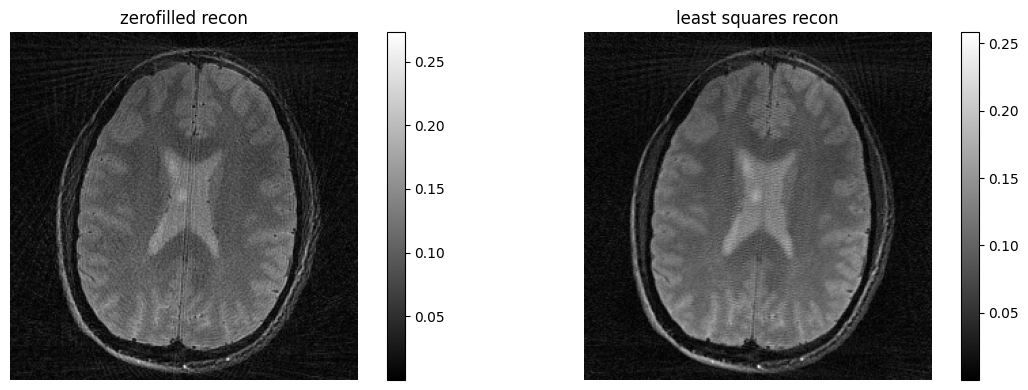

In [4]:
# plot
plt.rcParams['figure.figsize'] = [12, 4]

plt.subplot(1, 2, 1)
_ = plt.imshow(abs(torch.flip(img, dims=(-1,)).squeeze()).T, cmap="gray"), plt.axis("off"), plt.title("zerofilled recon"), plt.colorbar()
plt.subplot(1, 2, 2)
_ = plt.imshow(abs(torch.flip(img_lstsq, dims=(-1,)).squeeze()).T, cmap="gray"), plt.axis("off"), plt.title("least squares recon"), plt.colorbar()
plt.tight_layout()

In [5]:
print(F._ndim)

2


In [6]:
img_denoise_wav = deepmr.prox.wavelet_denoise(img_lstsq, 2, ths=0.01)
img_denoise_tv = deepmr.prox.tv_denoise(img_lstsq, 2, ths=0.01)

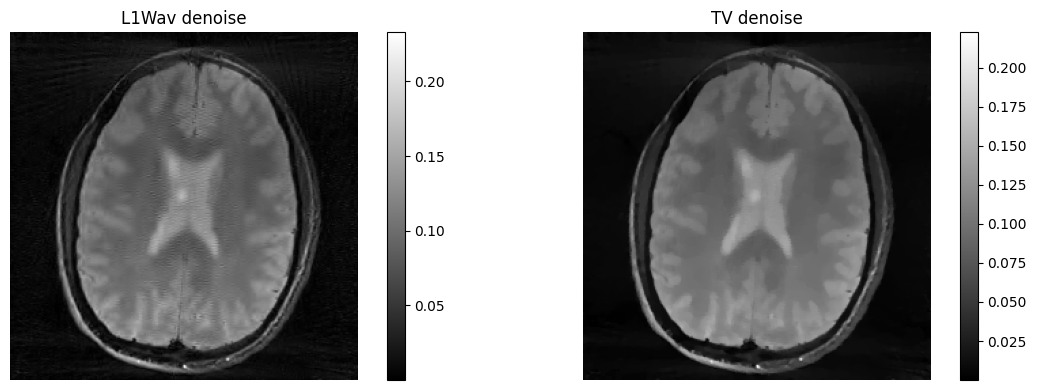

In [7]:
# plot
plt.rcParams['figure.figsize'] = [12, 4]

plt.subplot(1, 2, 1)
_ = plt.imshow(abs(torch.flip(img_denoise_wav, dims=(-1,)).squeeze()).T, cmap="gray"), plt.axis("off"), plt.title("L1Wav denoise"), plt.colorbar()
plt.subplot(1, 2, 2)
_ = plt.imshow(abs(torch.flip(img_denoise_tv, dims=(-1,)).squeeze()).T, cmap="gray"), plt.axis("off"), plt.title("TV denoise"), plt.colorbar()
plt.tight_layout()

In [8]:
from deepinv.optim import optim_builder
from deepinv.optim.data_fidelity import L2

# Logging parameters
verbose = True

params_algo = {"stepsize": 0.01, "g_param": 0.01, "lambda": 0.1}

max_iter = 10
early_stop = True

# Select the data fidelity term
data_fidelity = deepmr.optim.L2()

# Get Wavelet Prior
prior = deepmr.prox.WaveletPrior(ndim=2)

# instantiate the algorithm class to solve the IP problem.
model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
)

# recon
img_l1wav = model(img, EHE)


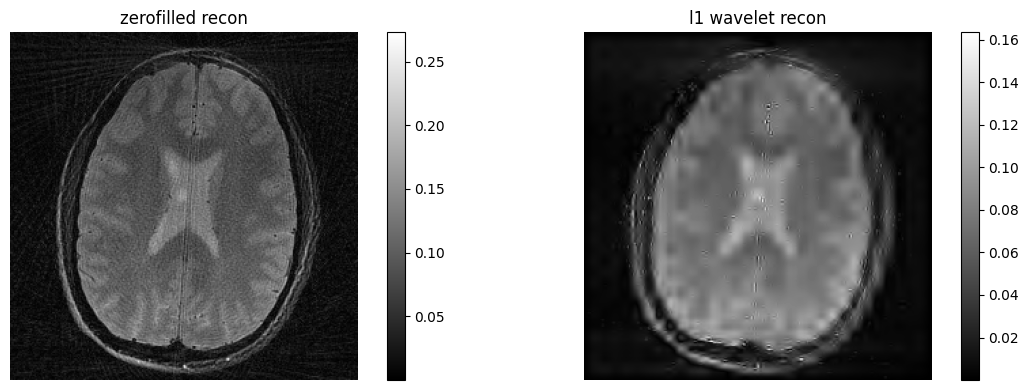

In [9]:
# plot
plt.rcParams['figure.figsize'] = [12, 4]

plt.subplot(1, 2, 1)
_ = plt.imshow(abs(torch.flip(img, dims=(-1,)).squeeze()).T, cmap="gray"), plt.axis("off"), plt.title("zerofilled recon"), plt.colorbar()
plt.subplot(1, 2, 2)
_ = plt.imshow(abs(torch.flip(img_l1wav, dims=(-1,)).squeeze()).T, cmap="gray"), plt.axis("off"), plt.title("l1 wavelet recon"), plt.colorbar()
plt.tight_layout()